# Hidden Markov Models (HMMs)

A popular choice of state space model (SSM) in time-series applications is the <b>hidden Markov model (HMM)</b>. In this notebook, we will provide an introduction on how to represent an HMM, how to perform posterior inference and find the most probable state path with this model, as well as how to estimate the HMM's parameters. 

Let's first import the necessary modules:

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors
# Color for 0 and 1
state_cmap = matplotlib.colors.ListedColormap(['orange', 'blue'])

import numpy as np

# GPU suitable form of NumPy, also works on the CPU
from jax import numpy as jnp
from jax import random as jr

# JAX library for SSMs
from dynamax.hidden_markov_model import CategoricalHMM

jnp.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness"
key = jr.PRNGKey(42)
np.random.seed(42)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

We will primarily use standard NumPy/[JAX](https://github.com/google/jax) syntax to dig into the details of the different HMM algorithms, but [Dynamax](https://github.com/probml/dynamax) will also be employed to illustrate how the same results can be achieved using a third-party library.

## Markov Chains

Markov chains are sequential models that assume an observation $\mathbf{x}_t$ at the current timestep $t$ is a <b>sufficient statistic</b> to predict the future:

\begin{equation*}
p(\mathbf{x}_{t+\tau} \, | \, \mathbf{x}_t, \mathbf{x}_{1:t-1}) = p(\mathbf{x}_{t+\tau} \, | \, \mathbf{x}_t),
\end{equation*}

for $\tau \geq 0$. In other words, given the present $\mathbf{x}_t$, the future is independent of the past. This is known as the <b>Markov assumption</b>. As a result, the joint distribution of a finite length sequence, with duration $T$, can be expressed as:

\begin{equation*}
p(\mathbf{x}_{1:T}) = p(\mathbf{x}_1) p(\mathbf{x}_2 \, | \, \mathbf{x}_1) p(\mathbf{x}_3 \, | \, \mathbf{x}_2) \ldots = p(\mathbf{x}_1) \prod_{t=2}^T p(\mathbf{x}_t \, | \, \mathbf{x}_{t-1}).
\end{equation*}


## State-Space Models (SSMs)

SSMs are <b>partially observed Markov chains</b>, which tells us two things about the dynamical system we are modeling:
1. The state of this dynamical system is only "partially observable", meaning there is a hidden variable, $\mathbf{z}_t \in \mathbb{R}^{N_z}$, that is assumed to be responsible for generating observations, $\mathbf{x}_t \in \mathbb{R}^{N_x}$, about the system's behavior.
2. The latent state's dynamics, $\mathbf{z}_t \in \mathbb{R}^{N_z}$, adhere to the Markov assumption.

Please refer to the [KF notebook](kalman_filter.ipynb#Posterior-Inference-in-SSMs) for a brief on the general problem of posterior inference in SSMs. As described in the KF notebook, we often assume that the observations are conditionally independent of one another, given $\mathbf{z}_t$, as opposed to being Markovian in their dependencies. An SSM can thus be described by the following joint distribution:

\begin{equation*}
p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T}) = \left[ p(\mathbf{z}_1) \prod_{t=2}^T p(\mathbf{z}_t \, | \, \mathbf{z}_{t-1}) \right] \left[ \prod_{t=1}^T p(\mathbf{x}_t \, | \, \mathbf{z}_{t}) \right],
\end{equation*}

where $p(\mathbf{z}_1)$ is the prior distribution, $p(\mathbf{z}_t \, | \, \mathbf{z}_{t-1})$ is the transition model, and $p(\mathbf{x}_t \, | \, \mathbf{z}_{t})$ is the observation model.

## HMM Representation

HMMs are SSMs with <b>discrete</b> hidden variables, $z_t \in \{1, \ldots, K\}$. This is in contrast to linear Gaussian SSMs or linear dynamical systems, which have continuous latent variables and can use the KF algorithm to recursively estimate the <i>belief state</i>, $p(\mathbf{z}_t \, | \, \mathbf{x}_{1:t})$. Note that the observations can be discrete, $x_t \in \{1, \ldots, N_x\}$, continuous, $\mathbf{x}_t \in \mathbb{R}^{N_x}$, or a mix of both.

The following walks through how to specify each of the distributions for this generative model, known as the HMM.

### State Transition Model

First, the <b>initial state distribution</b> can be written as:

\begin{equation*}
p(z_1 = j) = \pi_j,
\end{equation*}

for an arbitrary state $j$. We denote $\boldsymbol{\pi}$ as a categorical distribution over the $K$ states of the HMM.

The <b>transition model</b> can then be denoted as:

\begin{equation*}
p(z_t = j | z_{t-1} = i) = A_{ij},
\end{equation*}

where $\mathbf{A}$ is the $K \times K$ transition matrix (a row stochastic matrix, i.e., each row sums to one).

### Observation Model

On the other hand, the <b>observation likelihood</b>, $p(\mathbf{x}_t \, | \, z_{t} = j)$, is represented differently depending on the type of observation data, $\mathbf{x}_t$. For discrete observations or <i>emissions</i>, $x_t \in \{1, \ldots, N_x\}$, we could utilize:

\begin{equation*}
p(x_t = k \, | \, z_t = j) = B_{jk},
\end{equation*}

with $\mathbf{B}$ as the $K \times N_x$ observation matrix containing the emission probabilities. A similar form could be written for Bernoulli observations. For $D$ discrete observations per time step, or $D$ <i>number of emissions</i>, a factorial model could be adopted:

\begin{equation*}
p(\mathbf{x}_t \, | \, z_t = j) = \prod_{d=1}^D \text{Cat}(x_{td} \, | \, \mathbf{B}_{d,j,:}),
\end{equation*}

where $x_{td}$ is the $d^{th}$ observation at time $t$, and $\mathbf{B}_{d,j,:}$ is the $j^{th}$ row of the emission probabilities matrix for observation $d$.

Likewise, if $\mathbf{x}_t \in \mathbb{R}^{N_x}$ is continuous, then a common choice of likelihood model is the multivariate Gaussian distribution:

\begin{equation*}
p(\mathbf{x}_t \, | \, z_t = j) = \mathcal{N}(\mathbf{x}_t \, | \, \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j),
\end{equation*}

where $\boldsymbol{\mu}_j \in \mathbb{R}^{N_x}$ and $\boldsymbol{\Sigma}_j \in \mathbb{R}^{N_x \times N_x}$ are the mean and covariance matrix associated with the Gaussian distribution for hidden state $j$.

### Joint Distribution

To specify the joint distribution of an HMM, let's consider a <b>categorical HMM</b> with emissions $x_t$ that follow a categorical distribution. The parameters for this model are thus $\boldsymbol{\theta} = (\boldsymbol{\pi}, \mathbf{A}, \mathbf{B})$, with initial distribution, $\boldsymbol{\pi}$, transition matrix, $\mathbf{A}$, and emission probabilities, $\mathbf{B}$. The joint probability for a single sequence, i.e., the probability that $\mathbf{x}_{1:T}$ and $\mathbf{z}_{1:T}$ occur simultaneously, is then defined as:

\begin{align*}
p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T} \, | \, \boldsymbol{\theta}) & = \left[ p(z_1 \, | \, \boldsymbol{\pi}) \right] \left[ \prod_{t=2}^T p(z_t \, | \, z_{t-1}, \mathbf{A}) \right] \left[ \prod_{t=1}^T p(x_t \, | \, z_{t},\mathbf{B}) \right] \\
& = \left[ \prod_{k=1}^K \pi_k^{\mathbb{I}(z_1 = k)} \right] \left[ \prod_{t=2}^T \prod_{j=1}^K \prod_{k=1}^K A_{jk}^{\mathbb{I}(z_{t-1}=j,z_t = k)} \right] \left[ \prod_{t=1}^T \prod_{k=1}^K \text{Cat}(x_t \, | \, \mathbf{B}_k)^{\mathbb{I}(z_t = k)} \right],
\end{align*}

where the indicator functions extract specific elements of the different parameter structures, e.g., $\mathbb{I}(z_t = k)$ in the observation model refers to the $k^{th}$ row of matrix $\mathbf{B}$. 

## Weather Prediction Example

There are three fundamental problems in HMMs [(Rabiner, 1989)](https://ieeexplore.ieee.org/abstract/document/18626):
1. The <b>Evaluation/Scoring/Likelihood</b> problem: Given an HMM specified by known parameters, $\boldsymbol{\theta}$, and a sequence of observations, $\mathbf{x}_{1:T}$, what is the likelihood of this observation sequence, $p(\mathbf{x}_{1:T} \, | \, \boldsymbol{\theta})$?
2. The <b>Decoding</b> problem: Given an HMM specified by known parameters, $\boldsymbol{\theta}$, and a sequence of observations, $\mathbf{x}_{1:T}$, what is the most likely state sequence, $\mathbf{z}_{1:T}^*$, to produce these observations?
3. The <b>Learning</b> problem: Given an HMM and a sequence of observations or a set of $N$ observation sequences, $\{\mathbf{x}_{n,1:T}\}_{n=1}^N$, how do we find the parameters, $\boldsymbol{\theta}$, to maximize the likelihood, $\prod_n p(\mathbf{x}_{n, 1:T} \, | \, \boldsymbol{\theta})$?

Let's now ground these problems in the following weather prediction application. Suppose we have a friend, Maria, who performs daily activities based on the weather conditions. Assume we have no perfect information on the weather, but we are informed regularly on Maria's major day-to-day activities. Let's also assume that the weather can be modeled as a <b>discrete Markov chain</b>. On any given day, $t$, Maria performs one of three major activities: $x_t \in \{\text{clean}, \text{swim}, \text{shop}\}$, which we observe. The weather on this same day is instead <i>hidden</i> from us, but we know it can be described by two states: $z_t \in \{\text{rain}, \text{sun}\}$. Another similar weather prediction example could be on the basis of [whether Maria is holding an umbrella or not](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm#Example).

Under these conditions, we will consider the following HMM representation, with shaded nodes indicating observable variables:

<p align="center">
  <img src="../../docs/figures/hmm_weather.png?raw=true" width="478" height="340">
</p>

<br>

We can specify the parameters of our HMM, $\boldsymbol{\theta} = (\boldsymbol{\pi}, \mathbf{A}, \mathbf{B})$, as follows:

In [2]:
initial_probs = jnp.array([0.5, 0.5])
transition_matrix = jnp.array([[0.9, 0.1], 
                               [0.2, 0.8]])
emission_probs = jnp.array([[0.1, 0.6, 0.3],    # sun
                            [0.5, 0.1, 0.4]])   # rain

state_id_name_dict = {0: 'sun', 1: 'rain'}
observation_id_name_dict = {0: 'clean', 1: 'swim', 2: 'shop'}

print(f"π shape: {initial_probs.shape}")
print(f"A shape: {transition_matrix.shape}")
print(f"B shape: {emission_probs.shape}")

π shape: (2,)
A shape: (2, 2)
B shape: (2, 3)


Given $\boldsymbol{\theta}$, we can now instantiate the `CategoricalHMM` class of the Dynamax library to implement our HMM: 

In [3]:
num_states = 2      # two weather conditions
num_emissions = 1   # only one activity is observed per timestep/day
num_classes = 3     # each day can have one of three activities performed

# Construct the HMM
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

# Initialize the parameters struct with known values
params, _ = hmm.initialize(initial_probs=initial_probs,
                           transition_matrix=transition_matrix,
                           # Reshaped to accommodate a factorial model with D number of emissions
                           emission_probs=emission_probs.reshape(num_states, num_emissions, num_classes))
print(params)

ParamsCategoricalHMM(initial=ParamsStandardHMMInitialState(probs=Array([0.5, 0.5], dtype=float32)), transitions=ParamsStandardHMMTransitions(transition_matrix=Array([[0.9, 0.1],
       [0.2, 0.8]], dtype=float32)), emissions=ParamsCategoricalHMMEmissions(probs=Array([[[0.1, 0.6, 0.3]],

       [[0.5, 0.1, 0.4]]], dtype=float32)))


Note that Maria performs only a single major activity per day, $t$, so there is no need to consider $D$ discrete observations per time step, i.e., `num_emissions`. The `CategoricalHMM` does however accommodate this type of factorial model if desired.

To illustrate the inner workings of an HMM, we will also define a structure of our own to mimic functionality provided by Dynamax:

In [4]:
weather_hmm_params = {}
weather_hmm_params['pi'] = initial_probs
weather_hmm_params['A'] = transition_matrix
weather_hmm_params['B'] = emission_probs

### Sampling Data

Let's sample data from this HMM, assuming a full year of Maria's daily activities is observed $T=365$.

In [5]:
T = 365
true_states, emissions = hmm.sample(params, key, T)

print(f"States shape: {true_states.shape}")
# The last dimension of 1 here relates to the num_emissions parameter
print(f"Emissions shape: {emissions.shape}")
print("")
print("First week's states:    ", *map(state_id_name_dict.get, np.array(true_states[:7])))
print("First week's emissions: ", *map(observation_id_name_dict.get,  np.array(emissions[:7, 0])))    
    
# Using our own structure
def sample_hmm(theta, num_timesteps):
    # CDFs to draw categorical samples
    initial_probs_cdf = np.cumsum(theta['pi'])
    trans_mat_cdf = np.cumsum(theta['A'], axis=1)
    obs_mat_cdf = np.cumsum(theta['B'], axis=1)

    # Get random initial state
    curr_state = np.argmax(initial_probs_cdf > np.random.rand())
    state_sequence = [curr_state]

    # Generate first observation given this initial state
    observations = [np.argmax(obs_mat_cdf[curr_state] > np.random.rand())]

    # Generate sample sequence
    for t in range(num_timesteps - 1):
        # Apply transition matrix to draw next state
        curr_state = np.argmax(trans_mat_cdf[curr_state] > np.random.rand())
        state_sequence.append(curr_state)
        # Generate observation for the sampled state
        observations.append(np.argmax(obs_mat_cdf[curr_state] > np.random.rand()))
            
    return np.array(state_sequence), np.atleast_2d(observations).T

z, x = sample_hmm(weather_hmm_params, T)

print("")
print("")
print(f"Our z shape: {z.shape}")
print(f"Our x shape: {x.shape}")
print("")
print("First week's states:    ", *map(state_id_name_dict.get, z[:7]))
print("First week's emissions: ", *map(observation_id_name_dict.get,  x[:7, 0]))

States shape: (365,)
Emissions shape: (365, 1)

First week's states:     rain sun sun rain rain rain sun
First week's emissions:  shop swim shop clean clean shop swim


Our z shape: (365,)
Our x shape: (365, 1)

First week's states:     sun sun sun sun sun sun sun
First week's emissions:  shop swim swim shop shop shop swim


Let's plot the hidden state sequence:

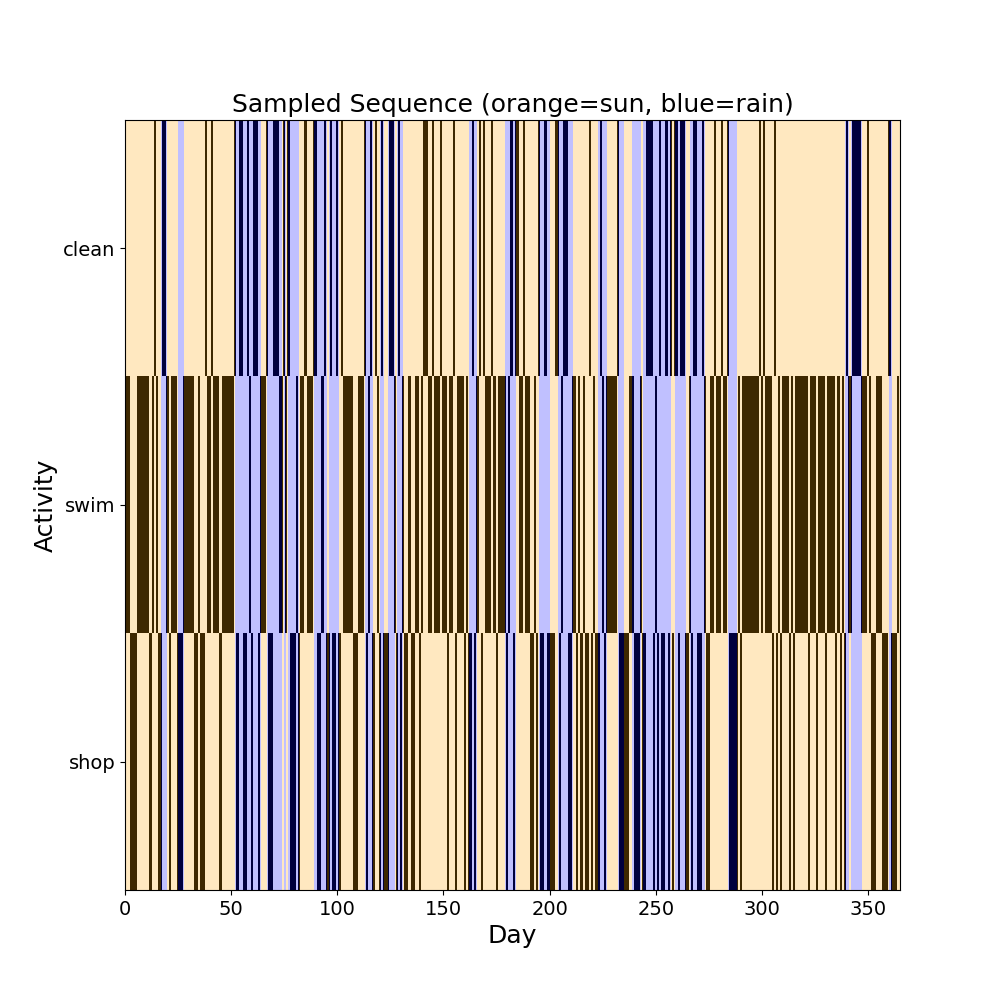

In [6]:
def plot_sequence(states, emissions):
    # Convert to one-hot to plot as an image (N_x, T)
    one_hot_emissions = np.squeeze(np.eye(num_classes)[emissions.reshape(-1)])

    fig = plt.figure(figsize=(10, 10))
    # Activities are color-coded gray when observed on a given day 
    # Transpose to have x-axis for days and y-axis for emission index
    plt.imshow(one_hot_emissions.T, aspect='auto', interpolation='none', cmap='Greys')
    
    # For the states image, we need an extra dimension to treat the 1D sequence as a 2D matrix
    # extent controls the space in the image that is filled 
    plt.imshow(states[None, :], extent=(0, T, num_classes-.5, -.5), 
               interpolation='none', aspect='auto', cmap=state_cmap, alpha=0.25)
    
    plt.xlabel("Day")
    plt.ylabel("Activity")
    plt.yticks(np.arange(num_classes), [observation_id_name_dict[i] for i in (np.arange(num_classes))])
    plt.title("Sampled Sequence (orange=sun, blue=rain)")
    plt.show()

#plot_sequence(true_states, emissions)
plot_sequence(z, x)

Maria is mostly swimming when it's sunny...

### The Evaluation Problem: Forward-Backward Algorithm

The first problem is to compute the likelihood of an observation sequence, $p(\mathbf{x}_{1:T} \, | \, \boldsymbol{\theta})$, given known parameters of the HMM, $\boldsymbol{\theta}$ (dropped for brevity in the following, as assumed known). Estimating this marginal likelihood can be useful when comparing and fitting models.

Suppose Maria has the 3-day activity sequence: <i>swim shop shop</i>. We want to find the probability of this sequence occurring, but we have no knowledge about a critical dependency: the weather, $z_t$. 

<b>Fully observable case:</b> For a Markov chain, where there are no hidden states, the likelihood could be calculated by simply tracing the emission events and multiplying probabilities along the arcs of the graph:

\begin{equation*}
p(\mathbf{x}_{1:T}) = p(x_1) p(x_2 \, | \, x_1) p(x_3 \, | \, x_2) \ldots p(x_T \, | \, x_{T-1}).
\end{equation*}

We can apply a similar simplification in our HMM application to weather prediction by pretending the hidden states are known, e.g., <i>sun sun rain</i>. The observation likelihood for a particular hidden state sequence would then be (remembering that observations are assumed conditionally independent of one another given $z_t$):

\begin{equation*}
p(\mathbf{x}_{1:T} \, | \, \mathbf{z}_{1:T})  = \prod_{t=1}^T p(x_t \, | \, z_{t}),
\end{equation*}

which for our example sequence would be:

\begin{equation*}
p(\text{swim} \ \text{shop} \ \text{shop} \, | \, \text{sun} \ \text{sun} \ \text{rain})  = p(\text{swim} \, | \, \text{sun}) \times p(\text{shop} \, | \, \text{sun}) \times p(\text{shop} \, | \, \text{rain}).
\end{equation*}

However, we do not know the hidden states! 

<b>Brute force:</b> For an HMM, a naïve approach to the problem of "scoring" an observation sequence would be to marginalize over all possible state sequences in the joint probability, $p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T})$:

\begin{equation*}
p(\mathbf{x}_{1:T})  = \sum_{z_1} \cdots \sum_{z_{T}} p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T}) = \sum_{z_1} \cdots \sum_{z_{T}} p(\mathbf{x}_{1:T} \, | \, \mathbf{z}_{1:T}) p(\mathbf{z}_{1:T}).
\end{equation*}

For the sequence <i>swim shop shop</i>, computing the marginal likelihood equates to summing over all possible weather conditions, weighted by their prior probability, i.e., $2^3$ possibilities:

\begin{equation*}
p(\text{swim} \ \text{shop} \ \text{shop})  = p(\text{swim} \ \text{shop} \ \text{shop}, \text{sun} \ \text{sun} \ \text{sun}) + p(\text{swim} \ \text{shop} \ \text{shop}, \text{sun} \ \text{sun} \ \text{rain})  + p(\text{swim} \ \text{shop} \ \text{shop}, \text{rain} \ \text{rain} \ \text{sun}) + \ldots
\end{equation*}

More generally, an HMM with $K$ hidden states and an observation sequence of length $T$, requires the evaluation of $K^T$ state sequences, since at every $t = 1, 2, \ldots, T$ there are $K$ possible states to visit. This is a prohibitively large number of calculations for most real-world tasks with moderately long sequences, e.g., $2^{365} \approx 10^{109}$ computations. 

<b>Dynamic programming:</b> Instead, we opt to use a [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming) approach that takes $O(K^2T)$ time. In essence, the idea is to exploit the conditional independence properties of the HMM and <i>recursively</i> calculate the <b>filtering distribution</b>:

\begin{equation*}
p(z_t \, | \, \mathbf{x}_{1:t})  \propto \sum_{z_1} \cdots \sum_{z_{t-1}} p(\mathbf{z}_{1:t}, \mathbf{x}_{1:t}),
\end{equation*}

from which we can also obtain the probability of the model evidence, $p(\mathbf{x}_{1:T})$.


#### The Forward Algorithm (Filtering)

In our KF notebook, [Bayesian filtering](kalman_filter.ipynb#Bayesian-Filtering) was presented as a means of recursively estimating the belief state $p(z_t \, | \, \mathbf{x}_{1:t})$ given the prior estimate $p(z_{t-1} \, | \, \mathbf{x}_{1:t-1})$. For HMMs, computing these probabilities across all timesteps in a recursive manner is referred to as the <b>forward algorithm</b>. We can thus define the <b>forward variable</b> as a vector $\alpha_t(j) \triangleq p(z_t = j \, | \, \mathbf{x}_{1:t})$ for an arbitrary hidden state $j$:

\begin{align*}
\require{cancel}
\alpha_t(j) = p(z_t = j \, | \, \mathbf{x}_{1:t}) = p(z_t = j \, | \, x_t, \mathbf{x}_{1:t-1}) &= \frac{p(z_t = j, x_t, \mathbf{x}_{1:t-1})}{p(x_t \, | \, \mathbf{x}_{1:t-1})} \\
& = \frac{p(x_t \, | \, z_t=j, \cancel{\mathbf{x}_{1:t-1}})p(z_t =j\, | \, \mathbf{x}_{1:t-1})}{p(x_t \, | \, \mathbf{x}_{1:t-1})},
\end{align*}

where $\mathbf{x}_{1:t-1}$ was cancelled out due to the conditional independence between observations in the HMM. Let's also introduce a variable to represent the local evidence, $\lambda_t(j) \triangleq p(x_t \, | z_t = j)$.

<b>Aside:</b> Most of the HMM literature defines the forward variable $\alpha'_t(j) \triangleq p(z_t = j, \mathbf{x}_{1:t})$ as a joint probability. Please refer to Chapter 9.2.3.4 of Murphy's Advanced Topics book on why this joint probability definition poses problems, such as being less numerically stable. Also note that the two definitions are easily relatable using Bayes rule, as shown above.

First, we derive the forward variable at time $t$ by performing the <b>predict step</b> to compute the one-step-ahead predictive density:

\begin{equation*}
\alpha_{t|t-1}(j) = p(z_t = j \, | \, \mathbf{x}_{1:t-1}) = \sum_i p(z_t = j \, | \, z_{t-1} = i)p(z_{t-1} = i \, | \, \mathbf{x}_{1:t-1}) = \sum_i A_{ij} \alpha_{t-1}(i),
\end{equation*}

where $A_{ij}$ is the transition probability from state $i$ to $j$ and $\alpha_{t-1}(i)$ is the previous forward path probability. We then perform the <b>update step</b> by applying Bayes rule:

\begin{equation*}
\alpha_{t}(j) =  \frac{1}{Z_t} p(x_t \, | \, z_{t} = j)p(z_{t} = j \, | \, \mathbf{x}_{1:t-1}) = \frac{1}{Z_t} \lambda_t(j) \alpha_{t|t-1}(j) = \frac{1}{Z_t} \lambda_t(j) \sum_i A_{ij} \alpha_{t-1}(i),
\end{equation*}

for normalization constant $Z_t \triangleq p(x_t \, | \, \mathbf{x}_{1:t-1})$. Here, the recursive calculation of $\alpha_t$ from $\alpha_{t-1}$ means we have circumvented exponential time complexity. The update step in matrix form is:

\begin{equation*}
\boldsymbol{\alpha}_{t} = \text{normalize}\left(\boldsymbol{\lambda}_t \odot (\mathbf{A}^\mathsf{T} \boldsymbol{\alpha}_{t-1})\right),
\end{equation*}

where $\boldsymbol{\lambda}_t \in \mathbb{R}^{K}$ is the local evidence vector and $\odot$ denotes elementwise multiplication (Hadamard product).

Additionally, the marginal likelihood estimate, $p(\mathbf{x}_{1:T})$, is returned at the terminating condition, $T$, of the observation sequence as a byproduct of this filtering procedure:

\begin{equation*}
p(\mathbf{x}_{1:T}) = \prod_{t=1}^T p(x_t \, | \, \mathbf{x}_{1:t-1}) = \prod_{t=1}^T Z_t
\end{equation*}

In practice, the probability of the marginal likelihood is computed in the log domain, $\log p(\mathbf{x}_{1:T})$, to avoid numerical underflow. Similarly, we should compute log probabilities of the conditional likelihood, $\log p(x_t \, | z_t = j)$, and combine with the state prior, $p(z_t=j \, | \, \mathbf{x}_{1:t-1})$, using the [log-sum-exp trick](https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations).

The forward algorithm is implemented simply using Dynamax as follows:

In [7]:
# Filtering applied to samples drawn from our HMM sampling routine
posterior = hmm.filter(params, x)
print(f"Marginal likelihood: {posterior.marginal_loglik: .2f}")
print(f"Filtered probabilities shape: {posterior.filtered_probs.shape}")

Marginal likelihood: -380.92
Filtered probabilities shape: (365, 2)


And via NumPy:

In [8]:
def normalize(u, axis=0):
    """Normalizes array of values along the axis to sum to one."""
    u_sum = u.sum(axis=axis)
    return u / u_sum, u_sum

def condition_on(log_lld, prior_probs):
    """
    Applies the log-sum-exp trick to avoid numerical underflow when
    combining conditional log likelihoods with prior probabilities.
    See Eq 28.30 in Murphy's 2023 Book 2 for implementation.
    """
    log_lld_max = log_lld.max()
    # Combine prior probabilities with scaled conditional log likelihoods to get posterior
    conditioned_probs = prior_probs * np.exp(log_lld - log_lld_max)
    conditioned_probs, norm = normalize(conditioned_probs)
    # Also computes the log normalization constant
    log_norm = np.log(norm) + log_lld_max
    return conditioned_probs, log_norm
    
def forward_algo(theta, emissions):
    T = emissions.shape[0]
    Z = 0.0
    filtered_probs = []
    
    # Computes log p(x_t | z_t), returning a (T, K) log likelihood matrix
    log_lld = np.log(theta['B'][:, emissions.squeeze(1)].T)
    
    # Get initial alpha and norm (predict)
    alpha_init, log_norm = condition_on(log_lld[0], theta['pi'])
    Z += log_norm
    filtered_probs.append(alpha_init)
    
    # Filtering procedure
    for t in range(1, T):
        # Predict step: A.T.dot(alpha_{t-1})
        predicted_probs = np.dot(theta['A'].T, filtered_probs[t-1])

        # Update step: normalize(lambda_t * predicted_probs)
        alpha_t, log_norm = condition_on(log_lld[t], predicted_probs)

        Z += log_norm
        filtered_probs.append(alpha_t)
        
    return Z, np.array(filtered_probs)

log_probs, forward_probs = forward_algo(weather_hmm_params, x)
print(f"Marginal likelihood: {log_probs: .2f}")
print(f"Filtered probabilities shape: {forward_probs.shape}")

Marginal likelihood: -380.92
Filtered probabilities shape: (365, 2)


Now that we have computed the marginal likelihood, $p(\mathbf{x}_{1:T})$, and the filtering distribution, $p(z_t \, | \, \mathbf{x}_{1:t})$, we can plot the latter result:

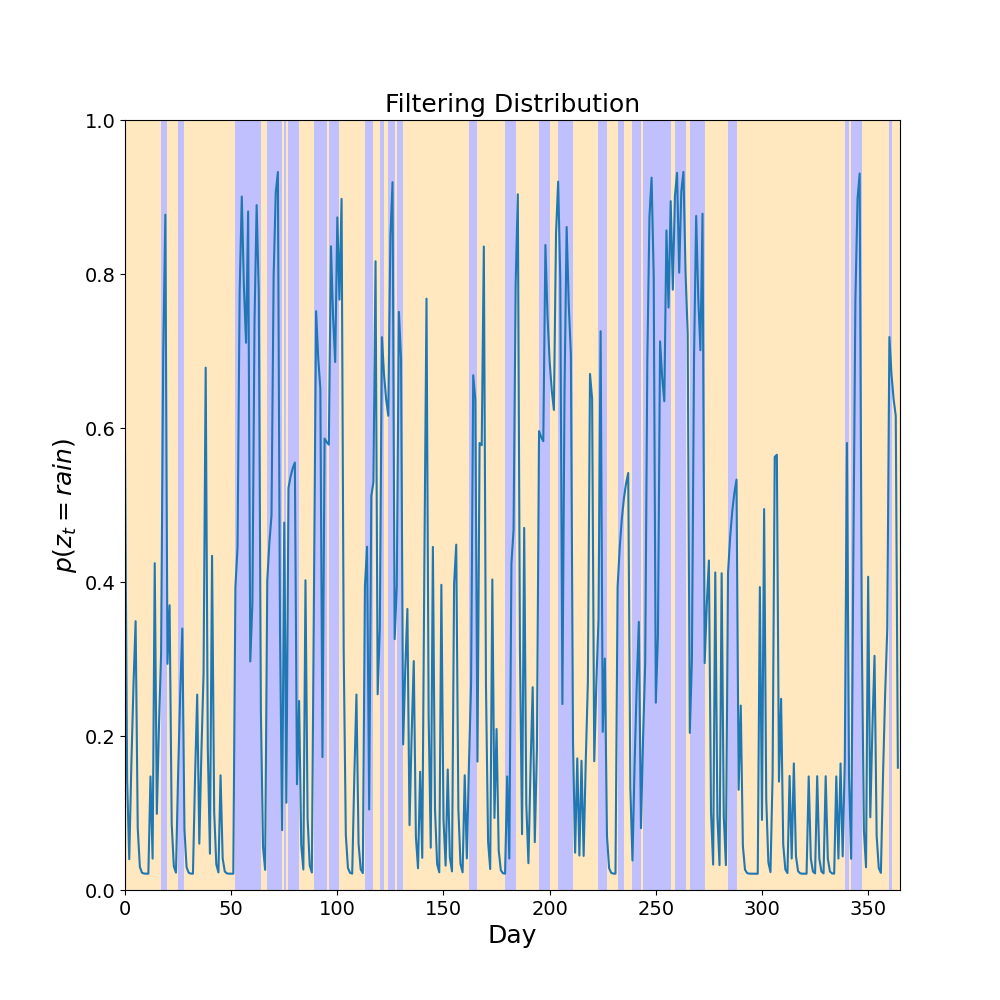

In [9]:
def plot_posterior_probs(probs, states, title=""):
    fig = plt.figure(figsize=(10, 10))
    
    plt.imshow(states[None, :], extent=(0, T, 0, 1), 
               interpolation='none', aspect='auto', cmap=state_cmap, alpha=0.25)
    plt.plot(probs[:, 1])   # probability of the weather being sunny (z=0)
    plt.xlabel("Day")
    plt.ylabel(r"$p(z_t = rain)$")
    plt.ylim(0, 1)
    plt.title(title)
    
    plt.show()
    
plot_posterior_probs(forward_probs, z, title="Filtering Distribution")

#### The Forward-Backward Algorithm (Smoothing)

Filtering in HMMs is an example of <i>online</i> inference. In the following, we will briefly outline an <i>offline</i> inference algorithm for HMMs, which is an example of Bayesian smoothing. More specifically, the aim is to compute the <b>smoothing distribution</b>:

\begin{equation*}
p(z_t \, | \, \mathbf{x}_{1:T})  \propto \sum_{z_1} \cdots \sum_{z_{t-1}} \sum_{z_{t+1}} \cdots \sum_{z_{T}} p(\mathbf{z}_{1:T}, \mathbf{x}_{1:T}).
\end{equation*}

The algorithm for calculating these smoothed marginals in HMMs is known as the <b>forward-backward algorithm</b>, as it entails the forward pass (filtering), followed by backward recursion. In the backward pass, a <b>backward variable</b>, $\beta_t(j) \triangleq p(\mathbf{x}_{t+1:T} \,|\, z_t=j)$, is introduced as the conditional likelihood of future evidence given that the hidden state at time $t$ is $j$. We can then derive the smoothed posterior marginal by combining the forward and backward variables:

\begin{align*}
\require{cancel}
\gamma_t(j) = p(z_t = j \, | \, \mathbf{x}_{1:T}) & = p(z_t = j \, | \, \mathbf{x}_{t+1:T}, \mathbf{x}_{1:t}) \propto p(z_t = j,  \mathbf{x}_{t+1:T} \, | \, \mathbf{x}_{1:t})  \\
&= p(z_t = j \, | \, \mathbf{x}_{1:t}) p(\mathbf{x}_{t+1:T} \, | \,  z_t = j, \cancel{\mathbf{x}_{1:t}}) = \alpha_t(j) \beta_t(j).
\end{align*}

In matrix notation:

\begin{equation*}
\boldsymbol{\gamma}_t = \text{normalize}(\boldsymbol{\alpha}_t \odot \boldsymbol{\beta}_t).
\end{equation*}

The following shows what the result would look like if using the Dynamax library:

In [10]:
# Runs the forward-backward (smoothing) algorithm
posterior = hmm.smoother(params, x)
print(f"Smoothed probabilities shape: {posterior.smoothed_probs.shape}")

#plot_posterior_probs(posterior.smoothed_probs, z, title="Smoothing Distribution")

Smoothed probabilities shape: (365, 2)


The $\beta$'s can be recursively calculated in a right-to-left fashion as follows:

\begin{align*}
\require{cancel}
\beta_{t-1}(i) & = p(\mathbf{x}_{t:T} \, | \,  z_{t-1} = i) \\
&= \sum_j p(z_t = j, x_t, \mathbf{x}_{t+1:T}  \, | \,  z_{t-1} = i) \\
&= \sum_j p(\mathbf{x}_{t+1:T} \, | \,  z_t = j, \cancel{x_t}, \cancel{z_{t-1} = i}) p(z_t = j, x_t \, | \,  z_{t-1} = i) \\
&= \sum_j p(\mathbf{x}_{t+1:T} \, | \,  z_t = j) p(x_t \, | \,  z_t = j, \cancel{z_{t-1} = i}) p(z_t = j \, | \,  x_t) \\
&= \sum_j \beta_t(j) \lambda_t(j) A_{ij},
\end{align*}

where the conditional independence properties of the HMM graph have allowed us to cancel out dependencies. The base case for the backward variables is $\beta_T(i) = p(\mathbf{x}_{T+1:T} \, | \, z_T = i) = p(\emptyset \, | \, z_T = i) = 1$. In matrix notation, the overall backward recursion can be written as:

\begin{equation*}
\boldsymbol{\beta}_{t-1} = \mathbf{A}(\boldsymbol{\lambda}_t \odot \boldsymbol{\beta}_t).
\end{equation*}

Below we show how to perform this backward recursion in code:

Marginal likelihood: -380.92
Smoothed probabilities shape: (365, 2)


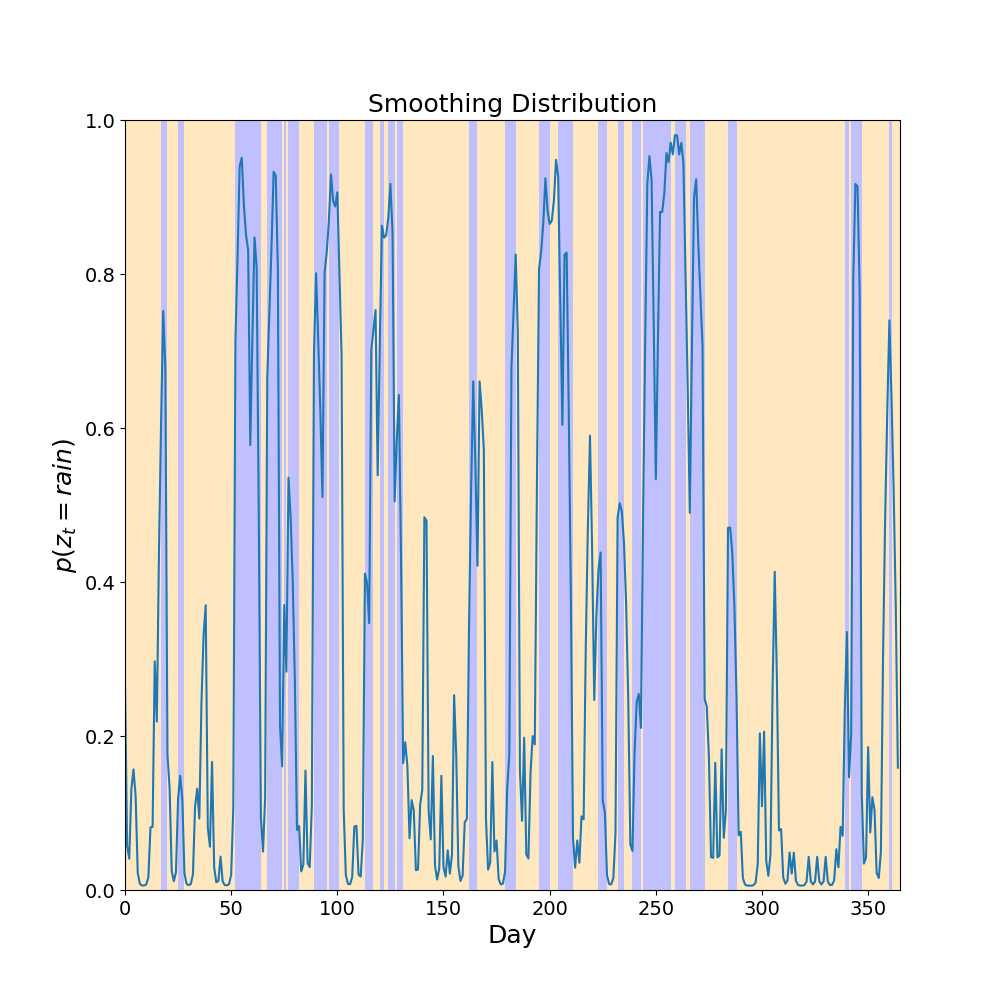

In [11]:
# Forward-backward algorithm
def fb_algo(theta, emissions):
    T = emissions.shape[0]
    K = theta['pi'].shape[0]

    # Run the forward algorithm
    log_norm, filtered_probs = forward_algo(theta, emissions)

    # Computes log p(x_t | z_t), returning a (T, K) log likelihood matrix
    log_lld = np.log(theta['B'][:, emissions.squeeze(1)].T)
        
    backward_probs = np.empty(shape=(T, K), dtype=np.float64)
    # Get initial beta (base case is probability of a non-event, i.e., 1)
    backward_probs[T-1] = 1.0
    smoothed_probs = np.empty(shape=(T, K), dtype=np.float64)
    smoothed_probs[T-1, :] = filtered_probs[-1]

    # Smoothing procedure
    for t in range(T-2, -1, -1):
        # Compute recursively the betas: A(lambda_t * beta_t)
        relative_probs_next, _ = condition_on(log_lld[t+1], backward_probs[t+1])
        backward_probs[t] = theta['A'].dot(relative_probs_next)

        # Smoothed posterior probabilities combine forward and backward variables: normalize(alpha_t * beta_t)
        smoothed_probs[t], _ = condition_on(np.log(filtered_probs[t]), backward_probs[t])
        
    return log_norm, filtered_probs, backward_probs, smoothed_probs

log_probs, forward_probs, backward_probs, smoothed_probs = fb_algo(weather_hmm_params, x)
print(f"Marginal likelihood: {log_probs: .2f}")
print(f"Smoothed probabilities shape: {smoothed_probs.shape}")

plot_posterior_probs(smoothed_probs, z, title="Smoothing Distribution")

Both the forward and forward-backward algorithms compute the probability of the evidence, $p(\mathbf{x}_{1:T})$. Nevertheless, given that the evaluation problem in HMMs is often solved "offline" with both past, $\mathbf{x}_{1:t}$, and future, $\mathbf{x}_{t+1:T}$, data available, it is more common to consider the forward-backward (smoothing) algorithm when estimating the marginal likelihood of an observation sequence. Moreover, smoothing significantly reduces uncertainty in our posterior estimates of the hidden states, as shown by the above plot. 

### The Decoding Problem: Viterbi Algorithm

The second problem is about finding the most probable state sequence, i.e., the <b>maximum a posteriori (MAP)</b> sequence, $\mathbf{z}_{1:T}^*$. In HMMs, this is known as <b>Viterbi decoding</b>. This decoding algorithm solves:

\begin{equation*}
\mathbf{z}_{1:T}^* = \mathop{\rm argmax}_{\mathbf{z}_{1:T}} p(\mathbf{z}_{1:T} \, | \, \mathbf{x}_{1:T}). 
\end{equation*}

Please note that the <i>jointly</i> most likely state sequence above is not necessarily the same as the sequence of <i>marginally</i> most probable states:

\begin{equation*}
\hat{\mathbf{z}}_{1:T} = \left(\mathop{\rm argmax}_{z_1} p(z_1 \, | \, \mathbf{x}_{1:T}), \ldots, \mathop{\rm argmax}_{z_T} p(z_T \, | \, \mathbf{x}_{1:T})\right),
\end{equation*}

which is given by the <b>maximizer of the posterior marginals (MPM)</b>. Decoding in HMMs predominantly refers to applying the Viterbi algorithm to obtain a globally consistent joint MAP estimate of the state sequence. 

In the following, we describe the Viterbi algorithm and how it derives $\mathbf{z}_{1:T}^*$ in $O(K^2T)$ time. While similar to the forward-backward algorithm, the two algorithms are not the same (beyond replacing the sum-operator for a max-operator). 

#### Forward Pass

The (unnormalized) forward variable was previously defined as:

\begin{equation*}
\alpha'_t(j) = p(z_t = j, \mathbf{x}_{1:t}) = \sum_{z_1, \ldots, z_{t-1}} p(\mathbf{z}_{1:t-1}, z_t =j, \mathbf{x}_{1:t}).
\end{equation*}
 
In the forward pass of the Viterbi algorithm, we define a new variable where the summation is replaced for the max-operator:

\begin{equation*}
\delta_t(j) \triangleq \max_{z_1, \ldots, z_{t-1}} p(\mathbf{z}_{1:t-1}, z_t =j, \mathbf{x}_{1:t}),
\end{equation*}

where $\delta_t(j)$ is the probability of ending up in state $j$ at time $t$ if the most probable path is taken. Given this information, $\delta_t(j)$ must also consist of the most probable path to some other state $i$ at time $t-1$, followed by a transition from $i$ to $j$:

\begin{equation*}
\delta_t(j) = \max_{i} \delta_{t-1}(i)A_{ij}\lambda_t(j).
\end{equation*}

This variable is initialized as $\delta_1(j) = \pi_j p(x_1 \, | \, z_1 = j)$. As usual, we work in the log domain to circumvent numerical issues, so the $\delta_t$ terms can instead by computed as:

\begin{equation*}
\log \delta_t(j) = \max_{i} \log \delta_{t-1}(i) + \log A_{ij} + \log \lambda_t(j).
\end{equation*}

We also need to track the most likely previous (<b>ancestor</b>) state, $\rho_t(j)$, for every possible state on the most probable path to $z_t = j$:

\begin{equation*}
\rho_t(j) = \mathop{\rm argmax}_i \delta_{t-1}(i)A_{ij}\lambda_t(j).
\end{equation*}

This plays a role in the subsequent backward pass of the Viterbi algorithm.

#### Backward Pass

In the backward pass, the most probable sequence of states is computed using <b>traceback</b>:

\begin{equation*}
z^*_t = \rho_{t+1}(z^*_{t+1}),
\end{equation*}

where we initialize this procedure with the most probable final state, $z_T^* = \mathop{\rm argmax}_i \delta_T(i)$. In essence, this procedure is simply tracing through the chain of ancestors along the MAP path.

With this, we now have the MAP sequence, $\mathbf{z}_{1:T}^*$. The following is the Viterbi algorithm's implementation in code. First using Dynamax:

In [12]:
def plot_map_sequence(most_likely_states, states):
    fig = plt.figure(figsize=(10, 10))
    
    plt.imshow(states[None, :], extent=(0, T, -0.05, 1.05), 
               interpolation='none', aspect='auto', cmap=state_cmap, alpha=0.25)
    plt.plot(most_likely_states)
    plt.xlabel("Day")
    plt.ylabel("MAP State")
    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 1])
    plt.title("Viterbi Estimate")
    
    plt.show()
    
# Runs the Viterbi algorithm
most_likely_states = hmm.most_likely_states(params, x)

#plot_map_sequence(most_likely_states, z)

Then using pure NumPy:

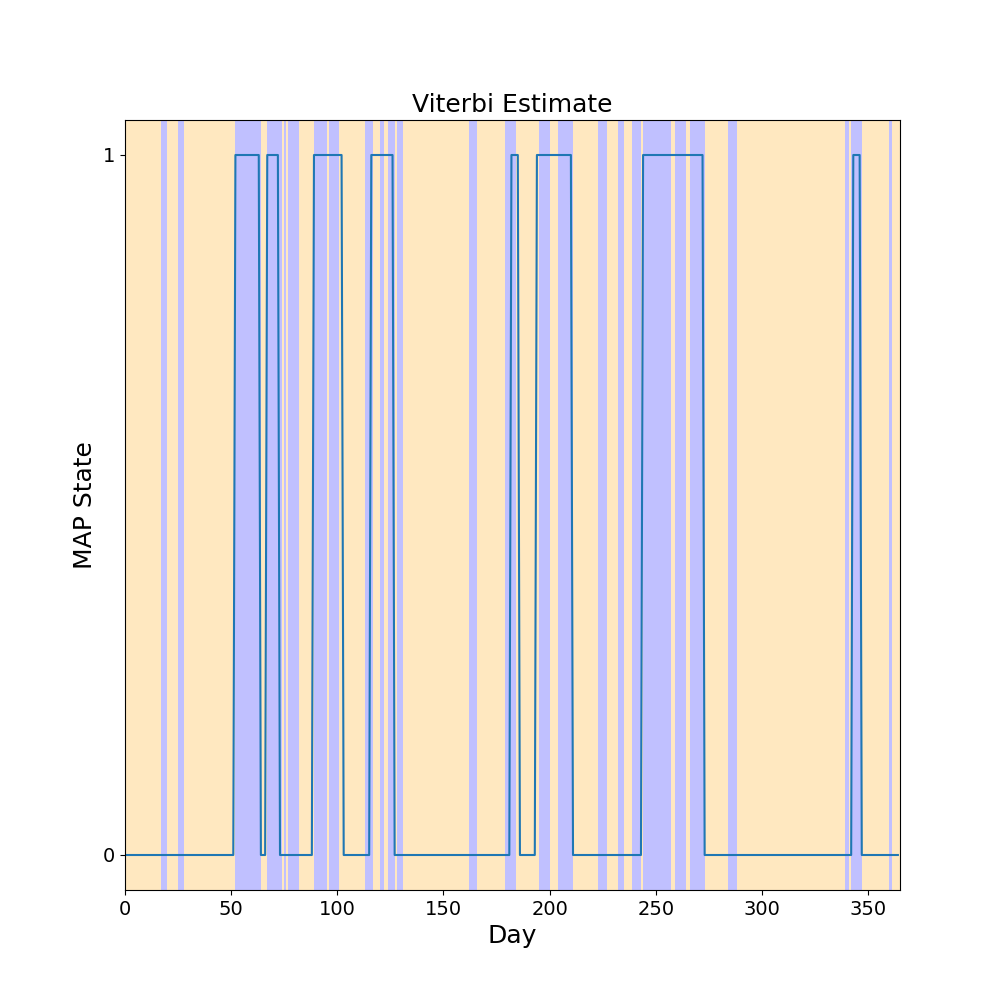

In [13]:
def viterbi_algorithm(theta, emissions):
    T = emissions.shape[0]
    K = theta['pi'].shape[0]
    
    # Computes log p(x_t | z_t), returning a (T, K) log likelihood matrix
    log_lld = np.log(theta['B'][:, emissions.squeeze(1)].T)
    # Log transition matrix
    log_A = np.log(theta['A'])
        
    ## Forward pass
    # Initialize delta_1
    deltas = [np.log(theta['pi']) + log_lld[0]]
    best_states = []
    for t in range(1, T):
        # Compute p(z_{1:t-1}, z_t=j x_{1:t}) for j=1,...,K
        scores = deltas[t-1] + log_A + log_lld[t]
        # K-length vector of probabilities assuming most probable path is taken
        delta_t = np.max(scores, axis=1)
        # K-length vector of most likely ancestor states (rho)
        best_states.append(np.argmax(scores, axis=1))
        deltas.append(delta_t)
    
    # deltas is currently a (T x K) Viterbi lattice
    # best_states is a (T-1 x K) state table 

    ## Backward pass
    # Initialize z*_T
    map_states = np.empty(shape=T, dtype=np.int32)
    map_states[T-1] = np.argmax(deltas[-1])

    # Traverse through most probable ancestor states in reverse
    for t in range(T-1, 1, -1):
        # t-2 for next best state in traceback, given a shifted by 1 state table   
        map_states[t-1] = best_states[t-2][map_states[t]]
    
    # Handle first state
    map_states[0] = np.argmax(np.log(theta['pi']) + log_lld[0] + deltas[1])

    return map_states
    
# Runs the Viterbi algorithm
z_map = viterbi_algorithm(weather_hmm_params, x)

# Plots the MAP sequence
plot_map_sequence(z_map, z)

The plot above shows that we have recovered the MAP path on weather states in the year based on observations of Maria's daily activities. 

### Further Reading on HMM Inference

Please refer to Chapter 9.2 of Murphy's "Probabilistic Machine Learning: Advanced Topics" book for more details on the above algorithms and topics regarding inference in HMMs.

### The Learning Problem: Baum-Welch Algorithm

The final problem in HMMs is for situations where the parameters of the model, $\boldsymbol{\theta}$, are not known and we need to estimate them. In other words, we need to learn the prior distribution, $\boldsymbol{\pi}$, the transition matrix, $\mathbf{A}$, and the emission matrix, $\mathbf{B}$. As the $z_t$ variables are hidden, we can view the situation as similar to fitting a mixturel model (if $z_t$ were instead observable, we could treat learning $\boldsymbol{\theta}$ as identical to fitting a generative classifier, e.g., via maximum likelihood estimation). Therefore, one of the most popular approaches to parameter fitting in HMMs is the EM algorithm. When applied to HMM, the EM algorithm is referred to as the <b>Baum-Welch</b> algorithm.

Please refer to the [notebook on EM for mixture models](../unsupervised_learning/em_gmm.ipynb) as a refresher on the algorithm, as we will dive straight into the two steps here. But first, let's define a `CategoricalHMM` without providing the known parameters:

In [14]:
hmm_learner = CategoricalHMM(num_states, num_emissions, num_classes)

# Returns the model parameters and the parameter properties
em_params, em_param_props = hmm_learner.initialize(key)

print("Randomly initialized parameters:")
print("π", em_params.initial.probs)
print("A", em_params.transitions.transition_matrix)
print("B", em_params.emissions.probs[:, 0, :]) # since num_emissions = 1

Randomly initialized parameters:
π [0.72948605 0.27051398]
A [[0.8233106  0.17668934]
 [0.39371032 0.60628974]]
B [[0.14211899 0.2508769  0.6070041 ]
 [0.33336854 0.5274099  0.13922146]]


We can populate our own structure with these randomly initialized parameters:

In [15]:
weather_hmm_learner_params = {}
weather_hmm_learner_params['pi'] = em_params.initial.probs
weather_hmm_learner_params['A'] = em_params.transitions.transition_matrix
weather_hmm_learner_params['B'] = em_params.emissions.probs[:, 0, :]

First, sample a batch of $N$ emission sequences, $\{\mathbf{x}_{n,1:T}\}_{n=1}^N$ (loosely speaking, representing $N$ periods of Maria reporting day-to-day activities):

In [16]:
# Sample a batch of N sequences, each with different lengths
N = 20
lengths = np.linspace(1000, 3000, N, endpoint=True, dtype=np.int32)

X_list = []
for t_n in lengths:
    # Use true HMM parameters when sampling dataset
    z_n, x_n = sample_hmm(weather_hmm_params, t_n)
    X_list.append(x_n)

X = np.vstack(X_list)
print(f"Batch emissions shape: {X.shape}") 

Batch emissions shape: (39991, 1)


#### E-step

Recall that the joint probability of the HMM for a single sequence can be written as:

\begin{align*}
p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T} \, | \, \boldsymbol{\theta}) = \left[ \prod_{k=1}^K \pi_k^{\mathbb{I}(z_1 = k)} \right] \left[ \prod_{t=2}^T \prod_{j=1}^K \prod_{k=1}^K A_{jk}^{\mathbb{I}(z_{t-1}=j,z_t = k)} \right] \left[ \prod_{t=1}^T \prod_{k=1}^K p(\mathbf{x}_t \, | \, \boldsymbol{\phi}_k)^{\mathbb{I}(z_t = k)} \right].
\end{align*}

The above considers a generic observation model, with parameters, $\boldsymbol{\phi}_k$, for state $k$. For instance, a categorical observation model, $\text{Cat}(x_t \, | \, \mathbf{B}_k)$, would have $\boldsymbol{\phi}_k = \mathbf{B}_k$, but this could also be $\boldsymbol{\mu_k}, \boldsymbol{\Sigma_k}$ if using a Gaussian observation model. Henceforth, we will consider a categorical emissions model.

In the E-step, we will infer the posterior distribution of the latent states, $\mathbf{z}_{1:T}$, given the parameters from the previous iteration, $\boldsymbol{\theta}^{old}$. This leads to the following surrogate objective function, a.k.a. the expected complete data log likelihood:

\begin{equation*}
Q(\boldsymbol{\theta}, \boldsymbol{\theta}^{old}) = \mathbb{E}_{p(\mathbf{z}_{1:T} \, | \, \mathbf{x}_{1:T}, \boldsymbol{\theta}^{old})}\left[\log p(\mathbf{x}_{1:T}, \mathbf{z}_{1:T} \, | \, \boldsymbol{\theta})\right],
\end{equation*}

which can be summed over $N$ observation sequences, $\{\mathbf{x}_{n,1:T}\}_{n=1}^N$.

For $N$ observation sequences, the expected complete data log likelihood can be shown to be:

\begin{equation*}
Q(\boldsymbol{\theta}, \boldsymbol{\theta}^{old}) = \sum_{k=1}^K \mathbb{E}[N_k^1] \log \pi_k + \sum_{j=1}^K \sum_{k=1}^K \mathbb{E}[N_{jk}] \log A_{jk} + \sum_{k=1}^K \mathbb{E}[N_{k}] \log \text{Cat}(x_{n, t} \, | \, \mathbf{B}_k),
\end{equation*}

where the expected counts are:

\begin{align*}
\mathbb{E}[N_k^1] & = \sum_{n=1}^N p(z_1 = k \, | \, \mathbf{x}_{n, 1:T_n}, \boldsymbol{\theta}^{old}) = \sum_{n=1}^N \gamma_{n,1}(k)\\
\mathbb{E}[N_{jk}] & = \sum_{n=1}^N \sum_{t=2}^{T_n} p(z_{t-1} = j, z_t = k \, | \, \mathbf{x}_{n, 1:T_n}, \boldsymbol{\theta}^{old}) = \sum_{n=1}^N \sum_{t=2}^{T_n} \xi_{n,t-1,t}(j,k) \\
\mathbb{E}[N_{k}] & = \sum_{n=1}^N \sum_{t=1}^{T_n} p(z_t = k \, | \, \mathbf{x}_{n, 1:T_n}, \boldsymbol{\theta}^{old}) = \sum_{n=1}^N \sum_{t=1}^{T_n} \gamma_{n,t}(k)
\end{align*}

with observation sequence $n$'s length denoted as $T_n$. The expected count under a categorical observation model are completely specified as:

\begin{equation*}
\mathbb{E}[M_{kv}] = \sum_{n=1}^N \sum_{t=1}^{T_n} \gamma_{n,t}(k) \mathbb{I}(x_{n,t} = v) = \sum_{n=1}^N \sum_{t:x_{n,t} = v} \gamma_{n,t}(k).
\end{equation*}

The expected sufficient statistics listed above are grouped across both time, $T$, and observation sequences, $N$. 

To acquire the required probabilities, $\gamma_{n,t}(j) \triangleq p(z_t = j \, | \, \mathbf{x}_{n, 1:T_n}, \boldsymbol{\theta}^{old})$ and $\xi_{n,t-1,t}(j,k) \triangleq p(z_{t-1} = j, z_t = k \, | \, \mathbf{x}_{n, 1:T_n}, \boldsymbol{\theta}^{old})$, the aforementioned forwards-backwards algorithm (smoothing) is performed on each sequence. The $\xi_{n,t-1,t}(j,k)$ variable is known as the <b>two-slice smoothed marginal</b>, which we do not derive in this notebook, but can be effectively calculated as:

\begin{equation*}
\xi_{t-1,t}(i, j) \propto \lambda_{t}(j)\beta_{t}(j)\alpha_{t-1}(i)A_{ij},
\end{equation*}

or in matrix form:

\begin{equation*}
\boldsymbol{\xi}_{t-1,t} \propto \mathbf{A} \odot \left[\boldsymbol{\alpha}_{t-1}(\boldsymbol{\lambda}_{t} \odot \boldsymbol{\beta}_{t})^\mathsf{T}\right].
\end{equation*}

To compute the expected sufficient statistics (E-step) in code:

In [17]:
# Computes the two-slice smoothed marginal probabilities
def compute_two_slice(theta, emissions, forward_probs, backward_probs):
    T = emissions.shape[0]

    # Computes log p(x_t | z_t), returning a (T, K) log likelihood matrix
    log_lld = np.log(theta['B'][:, emissions.squeeze(1)].T)
    
    two_slice_probs = []
    for t in range(T-1):
        # A * [a_{t-1}.dot(lambda_t * beta_t).T]
        relative_probs_next, _ = condition_on(log_lld[t+1], backward_probs[t+1])
        # Broadcasting to reshape vectors of shape (K,) to be (K, 1)
        smoothed_trans_probs = theta['A'] * forward_probs[t, :, None].dot(relative_probs_next[:, None].T)
        # Normalize for numerical stability
        smoothed_trans_probs /= smoothed_trans_probs.sum()
        
        two_slice_probs.append(smoothed_trans_probs)
    
    return np.array(two_slice_probs)

def e_step(theta, X, lengths):
    """
    Parameters
        theta : Parameters of the HMM model, i.e., prior probabilities, transition matrix and emissions matrix.
        X : Matrix of individual observation samples, shape (N*sum(lengths), N_x)
        lengths : Lengths of the individual sequences, T_n.
    
    Returns the expected sufficient statistics and the marginal log likelihood.
    """
    N = len(lengths)
    C = theta['B'].shape[1]
    
    # Dictionary structure to accumulate the sufficient statistics
    stats = {}
    stats['pi'] = np.zeros(theta['pi'].shape)
    stats['A'] = np.zeros(theta['A'].shape)
    stats['B'] = np.zeros(theta['B'].shape)

    total_log_prob = 0
    start_idx = 0
    # Foreach data case n
    for n in range(N):
        # Extract the relevant observation sequence
        x_n = X[start_idx:start_idx+lengths[n]]
        start_idx += lengths[n]

        # Run forward-backward algorithm on each sequence
        log_prob, forward_probs, backward_probs, smoothed_probs = fb_algo(theta, x_n)
        
        # Two-slice smoothed marginal for the transition matrix estimate
        two_slice_probs = compute_two_slice(theta, x_n, forward_probs, backward_probs)
        
        # One-hot encoding to compute expected sufficient stats for the observation matrix
        x_n_hot = np.squeeze(np.eye(C, dtype=int)[x_n.reshape(-1)])

        # Collect sufficient statistics, summing across N data examples
        stats['pi'] += smoothed_probs[0]             # E[N_k^1]
        stats['A'] += two_slice_probs.sum(axis=0)    # E[N_jk]
        stats['B'] += smoothed_probs.T.dot(x_n_hot)  # E[M_kv]
        
        # Accumulate evidence
        total_log_prob += log_prob
    
    return stats, total_log_prob

#### M-step

In this step of the EM algorithm, we update the parameters to maximize the $Q(\boldsymbol{\theta}, \boldsymbol{\theta}^{old})$ objective.

For the initial state probabilities, the transition probabilities, and the emission probabilities, we obtain the following estimates after maximizing the objective:

\begin{equation*}
\hat{\pi}_k = \frac{\mathbb{E}[N_k^1]}{N}, \quad \hat{A}_{jk} = \frac{\mathbb{E}[N_{jk}]}{\sum_{k'} \mathbb{E}[N_{jk'}]}, \quad \hat{B}_{kv} = \frac{\mathbb{E}[M_{kv}]}{\mathbb{E}[N_{k}]},
\end{equation*}

which are the normalized form of the expected counts. For instance, the transition probability estimate, $\hat{A}_{jk}$, is the expected number of transitions from state $j$ to $k$ (summed over all $t$) divided by the expected number of transitions from state $j$. Likewise, the emission probability estimate, $\hat{B}_{kv}$, can be interpreted as the expected number of times we are in state $k$ and observe symbol $v$ (summed over time), divided by the expected number of times we are in state $k$.

In [18]:
def m_step(stats, smoothed_probs):
    # stats['pi'].sum() equivalent to N
    init_prob = stats['pi'] / stats['pi'].sum()
    # Normalizing over expected counts, broadcasting for division along K rows
    trans_mat = stats['A'] / stats['A'].sum(axis=1)[:, None]
    obs_mat = stats['B'] / stats['B'].sum(axis=1)[:, None]

    return init_prob, trans_mat, obs_mat

#### EM Algorithm

The Baum-Welch (EM) algorithm then iteratively executes these two steps:

In [19]:
n_iter = 200
for i in range(n_iter):
    # Collect sufficient statistics
    stats, log_loss = e_step(weather_hmm_learner_params, X, lengths)
    
    # Maximize for estimates based on current parameters
    init_prob, trans_mat, obs_mat = m_step(stats, smoothed_probs)

    weather_hmm_learner_params['pi'] = init_prob
    weather_hmm_learner_params['A'] = trans_mat
    weather_hmm_learner_params['B'] = obs_mat
    
    if i % 10 == 0:
        print(f"EM loss at iteration {i} is: {log_loss}")
    
print("HMM parameters after EM fitting:")
print("π", weather_hmm_learner_params['pi'])
print("A", weather_hmm_learner_params['A'])
print("B", weather_hmm_learner_params['B'])

EM loss at iteration 0 is: -44042.68940240145
EM loss at iteration 10 is: -42640.26435802827
EM loss at iteration 20 is: -41853.881641437605
EM loss at iteration 30 is: -41655.6840079388
EM loss at iteration 40 is: -41609.81888227878
EM loss at iteration 50 is: -41588.61716400109
EM loss at iteration 60 is: -41581.39620852519
EM loss at iteration 70 is: -41579.35796755059
EM loss at iteration 80 is: -41578.83071807731
EM loss at iteration 90 is: -41578.6984070383
EM loss at iteration 100 is: -41578.665283995564
EM loss at iteration 110 is: -41578.65691085493
EM loss at iteration 120 is: -41578.65476462186
EM loss at iteration 130 is: -41578.65420661266
EM loss at iteration 140 is: -41578.65405965392
EM loss at iteration 150 is: -41578.65402052549
EM loss at iteration 160 is: -41578.65401001413
EM loss at iteration 170 is: -41578.654007170284
EM loss at iteration 180 is: -41578.65400639666
EM loss at iteration 190 is: -41578.654006185265
HMM parameters after EM fitting:
π [0.43213662 0.

The EM has converged to reasonably correct estimates of our true parameters. Note that the generated parameters have experienced <b>label switching</b> here, where state 0 is now "rain" and state 1 is "sun". This is because both EM solutions would have the same likelihood, with symmetrical priors, leading to two equally good posterior estimates. Typically we run a find-permutations procedure, as in our [GMM clustering](../unsupervised_learning/gmm_fitting_clustering.ipynb#GMM-Clustering) example, to recover the best correspondence between the latent variables and the true labels.

### Further Reading on HMM Learning

Please refer to Chapter 29.4 of Murphy's "Probabilistic Machine Learning: Advanced Topics" book for more on HMM parameter learning and the Baum-Welch algorithm.

## Additional Notes

Brief additional pointers:

### Baum-Welch Algorithm Initialization

As in our [EM notebook](../unsupervised_learning/em_gmm.ipynb), we need to take care in how the parameters are initialized to circumvent the issue of poor local optima. See Section 29.4.1.4 in Murphy's Advanced Topics book for some solutions, including using K-means or performing multiple random restarts.

### Choosing K

Similar to the problem of choosing the number of mixture components in EM parameter fitting for mixture densities, we can consider a variety of techniques for finding $K$, e.g., cross-validation with validation log likelihood. 

### Other Parameter Fitting Methods

EM is the most pervasive way of fitting the HMM's parameters, but it does not scale well to very large datasets. Check out [this notebook](https://github.com/probml/dynamax/blob/main/docs/notebooks/hmm/casino_hmm_learning.ipynb) for a comparison against other methods of training HMMs, e.g., via stochastic gradient descent.

### Other HMM Variants

There are a variety of extensions for the standard HMM. A few notable generalizations are:

- The <b>Hidden Semi-Markov Model (HSMM)</b>, which introduces a duration variable $d_t \in \{1, \ldots, D\}$ that acts as a counter on the time spent in a state, with $D$ as the maximum duration of any state.
- The <b>Hierarchical HMM (HHMM)</b>, where there are multiple "levels" of state chains. This is particularly useful for application domains with inherent hierarchy in their structure, such as speech recognition (words composed of phones, which are composed of subphones). HHMMs can be rolled out into a vanilla HMM, however the factored representation is easier to interpret and perform inference & training.
- The <b>Factorial HMM (FHMM)</b>, where a distributed representation of the hidden state is adopted, with multiple Markov latent chains stacked and tracked using a binary variable consisting of $m$ bits, i.e., $z_{t,m} \in \{0, 1\}$. The independence in these hidden chains is useful in reducing the computational complexity of standard HMM algorithms.
- And many more...

### Other HMM Libraries

Aside from Dynamax, two popular Python alternatives are:

- [hmmlearn](https://github.com/hmmlearn/hmmlearn) for an API similar to scikit-learn, except tailored to inference and unsupervised learning in HMMs; and
- [pomegranate](https://pomegranate.readthedocs.io/en/latest/#) for more extensive HMM development than that offered by hmmlearn, with efficient and parallelizable algorithms for model inference and fitting.

## References

Code adapted from <i>"casino_hmm_inference.ipynb"</i> and <i>"casino_hmm_learning.ipynb"</i> at:

@book{pml2Book,<br>
&emsp; author = "Kevin P. Murphy",<br>
&emsp; title = "Probabilistic Machine Learning: Advanced Topics",<br>
&emsp; publisher = "MIT Press",<br>
&emsp; year = 2023,<br>
&emsp; url = "http://probml.github.io/book2"<br>
}